In [1]:
import collections
from configparser import Interpolation
import torchvision
import torch
import torchvision.transforms.functional as F
from torchvision.transforms.functional import InterpolationMode
import random 
import numbers
import numpy as np
from PIL import Image

from collections.abc import Sequence

#
#  Extended Transforms for Semantic Segmentation
#
class ExtRandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a given probability.

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be flipped.

        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < self.p:
            return F.hflip(img), F.hflip(lbl)
        return img, lbl

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)


class ExtCompose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, lbl):
        for t in self.transforms:
            img, lbl = t(img, lbl)
        return img, lbl

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string


class ExtCenterCrop(object):
    """Crops the given PIL Image at the center.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """
        return F.center_crop(img, self.size), F.center_crop(lbl, self.size)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)


class ExtRandomScale(object):
    def __init__(self, scale_range, interpolation=InterpolationMode.BILINEAR):
        self.scale_range = scale_range
        self.interpolation = interpolation

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be scaled.
            lbl (PIL Image): Label to be scaled.
        Returns:
            PIL Image: Rescaled image.
            PIL Image: Rescaled label.
        """
        assert img.size == lbl.size
        scale = random.uniform(self.scale_range[0], self.scale_range[1])
        target_size = ( int(img.size[1]*scale), int(img.size[0]*scale) )
        return F.resize(img, target_size, self.interpolation), F.resize(lbl, target_size, self.interpolation)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        return self.__class__.__name__ + '(size={0}, interpolation={1})'.format(self.size, interpolate_str)

class ExtScale(object):
    """Resize the input PIL Image to the given scale.
    Args:
        Scale (sequence or int): scale factors
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """

    def __init__(self, scale, interpolation=F.InterpolationMode.BILINEAR):
        self.scale = scale
        self.interpolation = interpolation

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be scaled.
            lbl (PIL Image): Label to be scaled.
        Returns:
            PIL Image: Rescaled image.
            PIL Image: Rescaled label.
        """
        assert img.size == lbl.size
        target_size = ( int(img.size[1]*self.scale), int(img.size[0]*self.scale) ) # (H, W)
        return F.resize(img, target_size, self.interpolation), F.resize(lbl, target_size, F.InterpolationMode.BILINEAR)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        return self.__class__.__name__ + '(size={0}, interpolation={1})'.format(self.size, interpolate_str)


class ExtRandomRotation(object):
    """Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img, lbl):
        """
            img (PIL Image): Image to be rotated.
            lbl (PIL Image): Label to be rotated.
        Returns:
            PIL Image: Rotated image.
            PIL Image: Rotated label.
        """

        angle = self.get_params(self.degrees)

        return F.rotate(img, angle, self.resample, self.expand, self.center), F.rotate(lbl, angle, self.resample, self.expand, self.center)

    def __repr__(self):
        format_string = self.__class__.__name__ + '(degrees={0}'.format(self.degrees)
        format_string += ', resample={0}'.format(self.resample)
        format_string += ', expand={0}'.format(self.expand)
        if self.center is not None:
            format_string += ', center={0}'.format(self.center)
        format_string += ')'
        return format_string

class ExtRandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a given probability.
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < self.p:
            return F.hflip(img), F.hflip(lbl)
        return img, lbl

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)


class ExtRandomVerticalFlip(object):
    """Vertically flip the given PIL Image randomly with a given probability.
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be flipped.
            lbl (PIL Image): Label to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
            PIL Image: Randomly flipped label.
        """
        if random.random() < self.p:
            return F.vflip(img), F.vflip(lbl)
        return img, lbl

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)

class ExtPad(object):
    def __init__(self, diviser=32):
        self.diviser = diviser
    
    def __call__(self, img, lbl):
        h, w = img.size
        ph = (h//32+1)*32 - h if h%32!=0 else 0
        pw = (w//32+1)*32 - w if w%32!=0 else 0
        im = F.pad(img, ( pw//2, pw-pw//2, ph//2, ph-ph//2) )
        lbl = F.pad(lbl, ( pw//2, pw-pw//2, ph//2, ph-ph//2))
        return im, lbl

class ExtToTensor(object):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """
    def __init__(self, normalize=True, target_type='uint8', is_binary=True):
        self.normalize = normalize
        self.target_type = target_type
        self.is_binary = is_binary
    def __call__(self, pic, lbl):
        """
        Note that labels will not be normalized to [0, 1].
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
            lbl (PIL Image or numpy.ndarray): Label to be converted to tensor. 
        Returns:
            Tensor: Converted image and label
        """
        if self.is_binary:
            lbl = (np.array( lbl, dtype=self.target_type) / 255) + 1.0 - 1/255
            lbl = lbl.astype('long')
            return F.to_tensor(pic), torch.from_numpy( lbl )
        if self.normalize:
            return F.to_tensor(pic), torch.from_numpy( np.array( lbl, dtype=self.target_type) )
        else:
            return torch.from_numpy( np.array( pic, dtype=np.float32).transpose(2, 0, 1) ), torch.from_numpy( np.array( lbl, dtype=self.target_type) )

    def __repr__(self):
        return self.__class__.__name__ + '()'

class ExtNormalize(object):
    """Normalize a tensor image with mean and standard deviation.
    Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels, this transform
    will normalize each channel of the input ``torch.*Tensor`` i.e.
    ``input[channel] = (input[channel] - mean[channel]) / std[channel]``
    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor, lbl):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
            tensor (Tensor): Tensor of label. A dummy input for ExtCompose
        Returns:
            Tensor: Normalized Tensor image.
            Tensor: Unchanged Tensor label
        """
        return F.normalize(tensor, self.mean, self.std), lbl

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class ExtRandomCrop(object):
    """Crop the given PIL Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
        pad_if_needed (boolean): It will pad the image if smaller than the
            desired size to avoid raising an exception.
    """

    def __init__(self, size, padding=0, pad_if_needed=False):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.pad_if_needed = pad_if_needed

    @staticmethod
    def get_params(img, output_size):
        """Get parameters for ``crop`` for a random crop.
        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        w, h = img.size
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be cropped.
            lbl (PIL Image): Label to be cropped.
        Returns:
            PIL Image: Cropped image.
            PIL Image: Cropped label.
        """
        assert img.size == lbl.size, 'size of img and lbl should be the same. %s, %s'%(img.size, lbl.size)
        if self.padding > 0:
            img = F.pad(img, self.padding)
            lbl = F.pad(lbl, self.padding)

        # pad the width if needed
        if self.pad_if_needed and img.size[0] < self.size[1]:
            img = F.pad(img, padding=int((1 + self.size[1] - img.size[0]) / 2))
            lbl = F.pad(lbl, padding=int((1 + self.size[1] - lbl.size[0]) / 2))

        # pad the height if needed
        if self.pad_if_needed and img.size[1] < self.size[0]:
            img = F.pad(img, padding=int((1 + self.size[0] - img.size[1]) / 2))
            lbl = F.pad(lbl, padding=int((1 + self.size[0] - lbl.size[1]) / 2))

        i, j, h, w = self.get_params(img, self.size)

        return F.crop(img, i, j, h, w), F.crop(lbl, i, j, h, w)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0}, padding={1})'.format(self.size, self.padding)


class ExtResize(object):
    """Resize the input PIL Image to the given size.
    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """

    def __init__(self, size, interpolation=F.InterpolationMode.BILINEAR):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be scaled.
        Returns:
            PIL Image: Rescaled image.
        """
        return F.resize(img, self.size, self.interpolation), F.resize(lbl, self.size, F.InterpolationMode.BILINEAR)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        return self.__class__.__name__ + '(size={0}, interpolation={1})'.format(self.size, interpolate_str) 
    
class ExtColorJitter(object):
    """Randomly change the brightness, contrast and saturation of an image.

    Args:
        brightness (float or tuple of float (min, max)): How much to jitter brightness.
            brightness_factor is chosen uniformly from [max(0, 1 - brightness), 1 + brightness]
            or the given [min, max]. Should be non negative numbers.
        contrast (float or tuple of float (min, max)): How much to jitter contrast.
            contrast_factor is chosen uniformly from [max(0, 1 - contrast), 1 + contrast]
            or the given [min, max]. Should be non negative numbers.
        saturation (float or tuple of float (min, max)): How much to jitter saturation.
            saturation_factor is chosen uniformly from [max(0, 1 - saturation), 1 + saturation]
            or the given [min, max]. Should be non negative numbers.
        hue (float or tuple of float (min, max)): How much to jitter hue.
            hue_factor is chosen uniformly from [-hue, hue] or the given [min, max].
            Should have 0<= hue <= 0.5 or -0.5 <= min <= max <= 0.5.
    """
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)

    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - value, center + value]
            if clip_first_on_zero:
                value[0] = max(value[0], 0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with lenght 2.".format(name))

        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value

    @staticmethod
    def get_params(brightness, contrast, saturation, hue):
        """Get a randomized transform to be applied on image.

        Arguments are same as that of __init__.

        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        transforms = []

        if brightness is not None:
            brightness_factor = random.uniform(brightness[0], brightness[1])
            transforms.append(Lambda(lambda img: F.adjust_brightness(img, brightness_factor)))

        if contrast is not None:
            contrast_factor = random.uniform(contrast[0], contrast[1])
            transforms.append(Lambda(lambda img: F.adjust_contrast(img, contrast_factor)))

        if saturation is not None:
            saturation_factor = random.uniform(saturation[0], saturation[1])
            transforms.append(Lambda(lambda img: F.adjust_saturation(img, saturation_factor)))

        if hue is not None:
            hue_factor = random.uniform(hue[0], hue[1])
            transforms.append(Lambda(lambda img: F.adjust_hue(img, hue_factor)))

        random.shuffle(transforms)
        transform = Compose(transforms)

        return transform

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Input image.

        Returns:
            PIL Image: Color jittered image.
        """
        transform = self.get_params(self.brightness, self.contrast,
                                    self.saturation, self.hue)
        return transform(img), lbl

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += 'brightness={0}'.format(self.brightness)
        format_string += ', contrast={0}'.format(self.contrast)
        format_string += ', saturation={0}'.format(self.saturation)
        format_string += ', hue={0})'.format(self.hue)
        return format_string

class Lambda(object):
    """Apply a user-defined lambda as a transform.

    Args:
        lambd (function): Lambda/function to be used for transform.
    """

    def __init__(self, lambd):
        assert callable(lambd), repr(type(lambd).__name__) + " object is not callable"
        self.lambd = lambd

    def __call__(self, img):
        return self.lambd(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'


class Compose(object):
    """Composes several transforms together.

    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.

    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string


class GaussianPerturb(object):
    """Gaussian perturbation on a tensor image with mean and standard deviation.
    Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels, this transform
    will normalize each channel of the input ``torch.*Tensor`` i.e.
    ``input[channel] = (input[channel] - mean[channel]) / std[channel]``
    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
    """

    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor, lbl):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be perturbed.
            tensor (Tensor): Tensor of label. A dummy input for ExtCompose
        Returns:
            Tensor: Normalized Tensor image.
            Tensor: Unchanged Tensor label
        """
        gp = np.random.normal(self.mean, self.std, np.shape(tensor.numpy()))
        
        return tensor + torch.from_numpy(gp).type(torch.float32), lbl

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)



class GaussianBlur(object):
    """Blurs image with randomly chosen Gaussian blur.
    If the image is torch Tensor, it is expected
    to have [..., C, H, W] shape, where ... means an arbitrary number of leading dimensions.

    Args:
        kernel_size (int or sequence): Size of the Gaussian kernel.
        sigma (float or tuple of float (min, max)): Standard deviation to be used for
            creating kernel to perform blurring. If float, sigma is fixed. If it is tuple
            of float (min, max), sigma is chosen uniformly at random to lie in the
            given range.

    Returns:
        PIL Image or Tensor: Gaussian blurred version of the input image.

    """

    def __init__(self, kernel_size, sigma=(0.1, 2.0)):
        self.kernel_size = _setup_size(kernel_size, "Kernel size should be a tuple/list of two integers")
        for ks in self.kernel_size:
            if ks <= 0 or ks % 2 == 0:
                raise ValueError("Kernel size value should be an odd and positive number.")

        if isinstance(sigma, numbers.Number):
            if sigma <= 0:
                raise ValueError("If sigma is a single number, it must be positive.")
            sigma = (sigma, sigma)
        elif isinstance(sigma, Sequence) and len(sigma) == 2:
            if not 0.0 < sigma[0] <= sigma[1]:
                raise ValueError("sigma values should be positive and of the form (min, max).")
        else:
            raise ValueError("sigma should be a single number or a list/tuple with length 2.")

        self.sigma = sigma

    @staticmethod
    def get_params(sigma_min: float, sigma_max: float) -> float:
        """Choose sigma for random gaussian blurring.

        Args:
            sigma_min (float): Minimum standard deviation that can be chosen for blurring kernel.
            sigma_max (float): Maximum standard deviation that can be chosen for blurring kernel.

        Returns:
            float: Standard deviation to be passed to calculate kernel for gaussian blurring.
        """
        return torch.empty(1).uniform_(sigma_min, sigma_max).item()

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image or Tensor): image to be blurred.

        Returns:
            PIL Image or Tensor: Gaussian blurred image
        """
        sigma = self.get_params(self.sigma[0], self.sigma[1])
        return F.gaussian_blur(img, self.kernel_size, [sigma, sigma]), lbl

    def __repr__(self) -> str:
        s = f"{self.__class__.__name__}(kernel_size={self.kernel_size}, sigma={self.sigma})"
        return s


def _setup_size(size, error_msg):
    if isinstance(size, numbers.Number):
        return int(size), int(size)

    if isinstance(size, Sequence) and len(size) == 1:
        return size[0], size[0]

    if len(size) != 2:
        raise ValueError(error_msg)

    return size

In [2]:
from torchvision.transforms.functional import normalize

class Denormalize(object):
    def __init__(self, mean, std):
        mean = np.array(mean)
        std = np.array(std)
        self._mean = -mean/std
        self._std = 1/std

    def __call__(self, tensor):
        if isinstance(tensor, np.ndarray):
            return (tensor - self._mean.reshape(-1,1,1)) / self._std.reshape(-1,1,1)
        return normalize(tensor, self._mean, self._std)

<PIL.Image.Image image mode=RGB size=421x481 at 0x7F2131E21668>


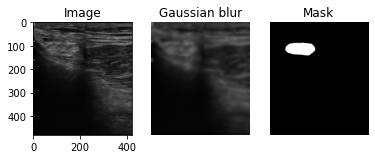

In [4]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

img = Image.open('/mnt/server5/sdi/datasets/CPN_all/Images/FN_I0020546.bmp').convert('RGB')
ma = Image.open('/mnt/server5/sdi/datasets/CPN_all/Masks/FN_I0020546_mask.bmp').convert('L')
result, ma = GaussianBlur(kernel_size=(49, 49), sigma=(5, 5))(img, ma)
print(result)

plt.subplot(131), plt.imshow(img, cmap='gray'), plt.title('Image')
plt.subplot(132), plt.imshow(np.array(result), cmap='gray'), plt.title('Gaussian blur'), plt.axis('off')
plt.subplot(133), plt.imshow(ma, cmap='gray'), plt.title('Mask'), plt.axis('off')
plt.show()

PIL image (481, 421, 3)
Tensor torch.Size([3, 481, 421])
torch.float64
torch.float32


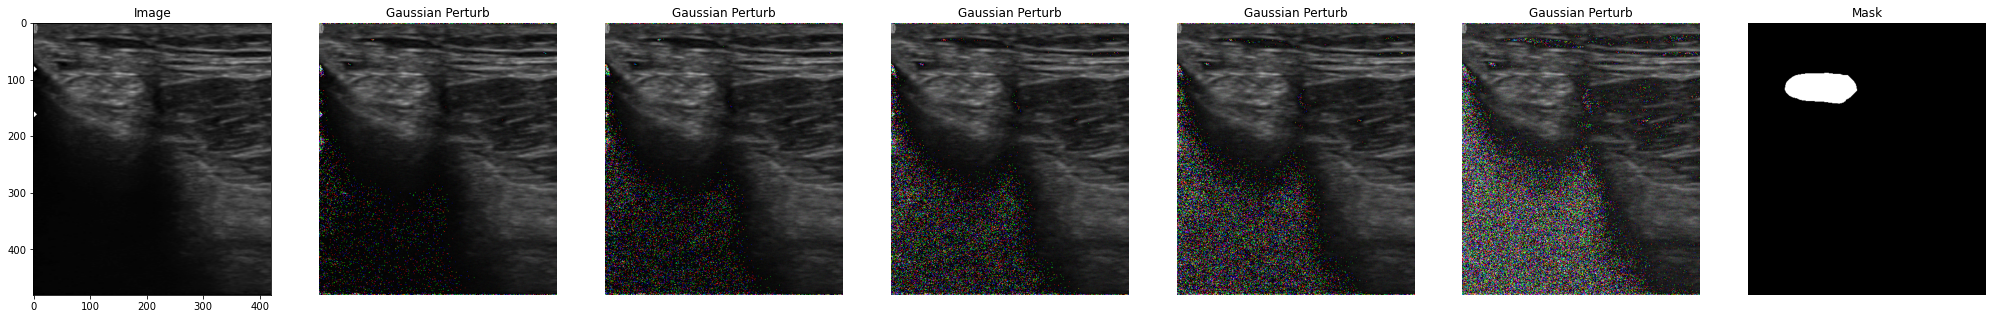

In [11]:
import utils

def genImage(im):
    denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return (denorm(im.numpy()) * 255).transpose(1, 2, 0).astype(np.uint8)

print('PIL image', np.shape(img))

ext_trans = [ ExtToTensor(), 
                ExtNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ]

pic, lbl = ext_trans[0](img, ma)
pic, lbl = ExtNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(pic, lbl)

gp = np.random.normal(0, 2, np.shape(pic.numpy()))

print('Tensor', pic.size())
torch.from_numpy(gp).size()

tmp = pic + torch.from_numpy(gp)
print(tmp.dtype)
print(pic.dtype)

tmp1, lbl = GaussianPerturb(std=0.05)(pic, lbl)
tmp2, lbl = GaussianPerturb(std=0.07)(pic, lbl)
tmp3, lbl = GaussianPerturb(std=0.09)(pic, lbl)
tmp4, lbl = GaussianPerturb(std=0.11)(pic, lbl)
tmp5, lbl = GaussianPerturb(std=0.2)(pic, lbl)

plt.figure(figsize=(35, 5))
plt.subplot(171), plt.imshow(img, cmap='gray'), plt.title('Image')
plt.subplot(172), plt.imshow(genImage(tmp1), cmap='gray'), plt.title('Gaussian Perturb'), plt.axis('off')
plt.subplot(173), plt.imshow(genImage(tmp2), cmap='gray'), plt.title('Gaussian Perturb'), plt.axis('off')
plt.subplot(174), plt.imshow(genImage(tmp3), cmap='gray'), plt.title('Gaussian Perturb'), plt.axis('off')
plt.subplot(175), plt.imshow(genImage(tmp4), cmap='gray'), plt.title('Gaussian Perturb'), plt.axis('off')
plt.subplot(176), plt.imshow(genImage(tmp5), cmap='gray'), plt.title('Gaussian Perturb'), plt.axis('off')
plt.subplot(177), plt.imshow(lbl, cmap='gray'), plt.title('Mask'), plt.axis('off')
plt.show()

In [ ]:
gp = np.random.normal(0, 20, (10, 10))
trans = GaussianPerturb(mean=0, std=100)
result, lbl = trans(img, ma)
#print(np.array(np.add(img, gp),).dtype)
print(np.array(result,).dtype)

plt.subplot(131), plt.imshow(img, cmap='gray'), plt.title('Image')
plt.subplot(132), plt.imshow(gp, cmap='gray'), plt.title('Gaussian'), plt.axis('off')
plt.subplot(133), plt.imshow(lbl, cmap='gray'), plt.title('Mask'), plt.axis('off')
plt.show()

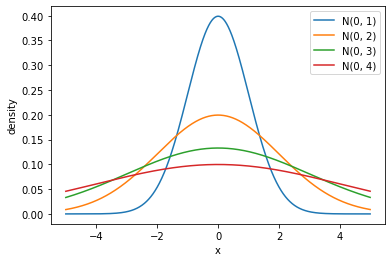

In [53]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-5, 5, 0.01)

def gaussian(x, mean, sigma):
    return (1 / np.sqrt(2*np.pi * sigma**2)) * np.exp(- (x-mean)**2 / (2*sigma**2))

legend = []
for i in range(1, 5):
    legend.append(f'N(0, {i})')
    plt.plot(x, gaussian(x, 0, i))

plt.xlabel('x')
plt.ylabel('density')
plt.legend(legend)
plt.show()

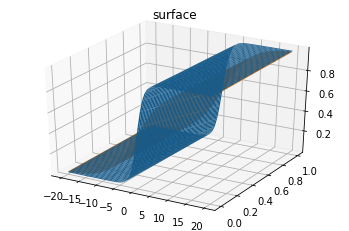

In [93]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection="3d")

def z_function(x, y, t):
    return np.exp(x / t) / (np.exp(x / t) + np.exp(y / t))

x = np.linspace(-20, 20, 60)
y = np.linspace(0, 1, 60)

X, Y = np.meshgrid(x, y)
Z = z_function(X, Y, 1.0)
Z2 = z_function(X, Y, 4.0)

ax.plot_wireframe(X, Y, Z, color='green')
ax.plot_wireframe(X, Y, Z2, color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, edgecolor='none')
ax.plot_surface(X, Y, Z2, rstride=1, cstride=1, edgecolor='none')
ax.set_title('surface')

plt.show()

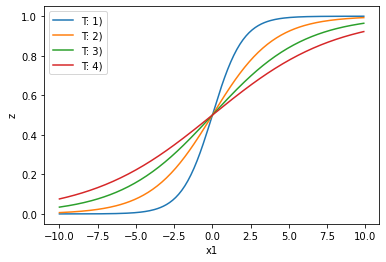

In [108]:
import numpy as np
import matplotlib.pyplot as plt

x1 = np.arange(-10, 10, 0.1)

def soft_label(x, y, t):
    return np.exp(x / t) / (np.exp(x / t) + np.exp(y / t))

legend = []
for i in range(1, 5):
    legend.append(f'T: {i})')
    plt.plot(x1, soft_label(x1, -0.0, i))

plt.xlabel('x1')
plt.ylabel('z')
plt.legend(legend)
plt.show()